In [28]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
%matplotlib inline

In [2]:
path = "/labs/mignot/DGN/BLAST"
zero_path = os.path.join(path, "zero")
one_path = os.path.join(path, "one")
two_path = os.path.join(path, "two")
J24_2 = "TRAJ24*02" # "TRAJ28*01"
J24_3 = "TRAJ24*03"

In [3]:
f = open("/home/ashteng/allJCodes.txt", "r")
all_j_codes = set([x.strip() for x in f.readlines()])

In [4]:
genotype_name_path_dict = {"GG": zero_path, "GC": one_path, "CC": two_path}
genotype_name_dose_dict = {"GG": 0, "GC": 1, "CC": 2}

In [5]:
df = pd.DataFrame(columns=["patid", "genotype", "dose", "transcript", "count"])
for genotype in genotype_name_path_dict.keys(): # zero, one, two
    genotype_path = genotype_name_path_dict[genotype]
    for file in os.listdir(genotype_path): # for each person
        patid, extension = file[:-4], file[-4:]
        if extension == ".out":
            filepath = os.path.join(genotype_path, file)
            with open(filepath, "r") as f:
                all_j_codes_dict = {x:0 for x in all_j_codes} # each person has a counts distribution over all J codes
                for line in f:
                    match = line.split()[1]
                    if match in all_j_codes_dict:
                        all_j_codes_dict[match] += 1
                    else:
                        print("Error: unknown match {} from {}.".format(match, filepath))
                for j_code in all_j_codes_dict:
                    df = df.append({"patid": patid, "genotype": genotype, "dose": genotype_name_dose_dict[genotype], "transcript": j_code, "count": all_j_codes_dict[j_code]}, ignore_index=True)

In [6]:
assert len(all_j_codes_dict) == len(df['transcript'].unique()) == len(df[df['patid'] == 'LD0420'])
df.to_csv("allJCounts.txt")

In [7]:
df = pd.read_csv("allJCounts.txt", index_col=0)

In [8]:
transcript_family_subtype_df = df["transcript"].str.split("*", n = 1, expand = True).rename(columns={0:"family", 1:"subtype"})

In [9]:
df["family"] = transcript_family_subtype_df["family"]
df["subtype"] = transcript_family_subtype_df["subtype"]

In [10]:
df.head()

,patid,genotype,dose,transcript,count,family,subtype
0,LD0176,GG,0,TRBJ2-4*01,52,TRBJ2-4,01
1,LD0176,GG,0,TRAJ07*01,10,TRAJ07,01
2,LD0176,GG,0,TRAJ43*01,14,TRAJ43,01
3,LD0176,GG,0,TRAJ16*01,2,TRAJ16,01
4,LD0176,GG,0,TRAJ19*01,0,TRAJ19,01


In [12]:
patid_genotype_df = df[['patid', 'genotype', 'dose']].drop_duplicates()
patid_genotype_df.head()
patid_genotype_df.to_csv("patid_genotype.csv")

In [13]:
total_j_count_df = df[["patid", "count"]].groupby("patid").sum().rename(columns={"count":"total_J_count"}).reset_index()
total_j_count_df.head()

,patid,total_J_count
0,LD0002,2979
1,LD0003,2399
2,LD0006,3086
3,LD0007,3353
4,LD0008,2871


In [14]:
df_with_total = pd.merge(df, total_j_count_df, how="inner", on="patid")
df_with_total["ratio"] = df_with_total["count"]/df_with_total["total_J_count"]

In [41]:
def drawFamilyBoxPlots(query_transcripts, plot_column="ratio"):
    # query_transcripts can be single, or list of multiple, which will be summed together
    summed_plot_column = "summed_{}".format(plot_column)
    
    # filter out rows that match query_transcripts
    filtered_transcripts_df = df_with_total[df_with_total['transcript'].isin(query_transcripts)]
    
    # sum up all row values by groupby patid
    summed_filtered_transcripts_df = filtered_transcripts_df[['patid', plot_column]].groupby('patid').sum().reset_index().rename(columns={plot_column:summed_plot_column})
    
    # add metadata about genotypes and dose
    plot_df = pd.merge(summed_filtered_transcripts_df, patid_genotype_df)

    fig, ax = plt.subplots()
    sns.boxplot(x="genotype", y=summed_plot_column, data=plot_df, order=["GG", "GC", "CC"], ax=ax)
    sns.regplot(x="dose", y=summed_plot_column, data=plot_df, x_estimator=np.mean, color="yellow", ax=ax, label="Mean Estimator")
    #sns.scatterplot(x="dose", y=summed_plot_column, data=plot_df)
    X = plot_df['dose'].values
    y = plot_df[summed_plot_column].values
    XX = sm.add_constant(X.flatten())
    mod = sm.OLS(y, XX)
    res = mod.fit()
    print('Parameters: ', res.params)
    print('R2: ', res.rsquared)
    print('p values:', res.pvalues)
    print(res.summary())
    
    plt.legend()
    plt.title("BLAST {} {}".format(query_transcripts, summed_plot_column))

Parameters:  [11.82934387 -1.25160741]
R2:  0.009643759381564032
p values: [1.45116876e-109 2.07895234e-002]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.375
Date:                Mon, 21 Oct 2019   Prob (F-statistic):             0.0208
Time:                        10:24:59   Log-Likelihood:                -1891.7
No. Observations:                 554   AIC:                             3787.
Df Residuals:                     552   BIC:                             3796.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

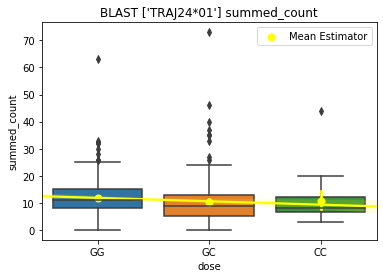

In [42]:
drawFamilyBoxPlots(["TRAJ24*01"], "count")

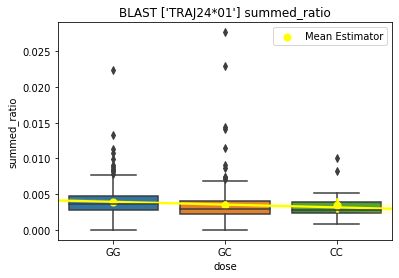

In [19]:
drawFamilyBoxPlots(["TRAJ24*01"], "ratio")

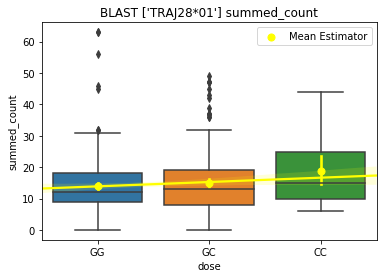

In [17]:
drawFamilyBoxPlots(["TRAJ28*01"], "count")

### Old Code

In [ ]:
# # transform into wide-form to compare with Sharon's counts

# patid_family_counts_df = df[['patid', 'family', 'count']].groupby(['patid', 'family']).sum().reset_index()
# sampled_people = patid_family_counts_df.patid.unique()
# patid_family_counts_df = patid_family_counts_df.pivot(index='family', columns='patid', values='count')
# patid_family_count_dict = patid_family_counts_df.to_dict()
# pickle.dump(patid_family_count_dict, open("patid_family_count_dict.pkl", "wb"))

In [ ]:
J24_2_count_df = df[df['transcript'] == J24_2][["patid", "count"]].set_index("patid").rename(columns={"count": "J24_2_count"})
J24_2_count_df.head()

In [ ]:
J24_3_count_df = df[df['transcript'] == J24_3][["patid", "count"]].set_index("patid").rename(columns={"count": "J24_3_count"})
J24_3_count_df.head()

In [ ]:
metadata_df = df[['patid', 'genotype', 'dose']].drop_duplicates().set_index("patid")
metadata_df.head()

In [ ]:
final_df = metadata_df.join([total_j_count_df, J24_2_count_df, J24_3_count_df])
final_df.head()

In [ ]:
final_df['J24_count'] = final_df['J24_2_count'] + final_df['J24_3_count']
final_df['J24_ratio'] = final_df['J24_count'] / final_df['count']
final_df['J24_2_ratio'] = final_df['J24_2_count'] / final_df['count']
#final_df['J24_2_ratio'] = (final_df['J24_2_ratio'] - np.mean(final_df['J24_2_ratio'])) / np.std(final_df['J24_2_ratio'])
final_df['J24_3_ratio'] = final_df['J24_3_count'] / final_df['count']
final_df.head()

In [ ]:
ax = sns.boxplot(x="genotype", y="J24_2_ratio", data=final_df)
plt.title(J24_2 + " Ratio")

In [ ]:
ax = sns.boxplot(x="genotype", y="J24_3_ratio", data=final_df)
plt.title(J24_3 + " Ratio")

In [ ]:
ax = sns.boxplot(x="genotype", y="J24_ratio", data=final_df)
plt.title("All J24 Ratio")

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X, y = final_df["dose"].to_numpy().reshape(-1, 1), final_df["J24_ratio"]
reg = LinearRegression().fit(X, y)

In [ ]:
reg.score(X, y) #R^2

In [ ]:
reg.coef_, reg.intercept_ 

In [ ]:
pred_y = reg.predict(X)

In [ ]:
ax = sns.lmplot(x="dose", y="J24_ratio", data=final_df, x_estimator=np.mean)

In [ ]:
# ax = sns.lmplot(x="dose", y="count", hue="transcript", data=df, x_estimator=np.mean)
# plt.title("Relationship between C allele dose and J24 subtype transcript counts")

In [ ]:
import sklearn
from sklearn import feature_selection
sklearn.feature_selection.f_regression(X, y)
XX = sm.add_constant(X.flatten())
mod = sm.OLS(y, XX)
res = mod.fit()

In [ ]:
res.pvalues

In [ ]:
print(res.summary())